# Debiasing with Orthogonalization

인과 모델을 평가하는 일은 거대한 일입니다. 측정할 수 없는 $\frac{\delta y}{\delta t}$를 평가해야 하기 때문입니다. 모델 예측값에 대한 정답지(`ground truth`)를 확인할 수 없으므로 창의적으로 인과 모델을 평가는 방법을 만들었습니다.

앞에서 배운 방법은 `treatment`(처치)가 무작위로 할당된 데이터에 크게 의존합니다. 기본 아이디어는 탄력성 $\frac{\delta y}{\delta t}$를 단일 변수를 가지는 선형 회귀 `y ~ t`로 추정하는 것입니다. 이 방법은 처치가 무작위로 할당되었을 때만 사용할 수 있으며, 그렇지 않으면 누락된 편향으로 문제가 발생합니다.

문제를 해결하기 위해서는 처치가 무작위로 할당된 것처럼 만들어야 합니다. 이를 위해 두 가지 방법, 성향 점수와 직교화를 사용할 수 있습니다. 여기서는 직교화를 다룰 예정입니다.

시작 전에 한가지 주의하고자 합니다. 가장 안전한 방법은 무작위 데이터를 수집하기 위한 실험을 수행하는 것이라 생각합니다. 개인적으로는 편향을 없애는 기술을 별로 신뢰하지 않습니다. 모든 교란자(`confounder`)를 고려하고 있는지 알 수 없기 때문입니다. 여전히 직교화는 배울 가치가 있습니다. 직교화는 매우 강력한 기술로 앞으로 다가올 많은 인과 모델의 기초가 됩니다.

## Linear Regression Reborn

직교화 아이디어는 1933년 세 명의 경제학자(Ragnar Frisch, Frederick V. Waugh, Michael C. Lovell)에 의해 정립된 정리를 기반으로 합니다. 단순하게 말하자면 어떠한 다변량 선형 회귀 모델을 세 단계 (또는 모델)로 분해하는 방법입니다. `feature` $X$ 행렬이 있다고 해봅시다. 이제 $X$를 $X_1$, $X_2$로 나눕니다.

먼저 $X_1$로 선형 회귀 모델을 얻습니다.

$$
y_i = \theta_0 + \pmb{\theta_1 X}_{1i} + e_i
$$

$\pmb{\theta_1}$는 매개 변수 벡터를 의미합니다. 그런 다음 이 모델의 잔차를 구합니다.

$$
y^* = y_i - (\hat{\theta}_0 + \pmb{\hat{\theta}_1 X}_{1i})
$$

두 번째 단계에서는 $X_1$로 $X_2$를 추정하는 모델을 만듭니다.

$$
\pmb{X}_{2i} = \gamma_0 + \pmb{\gamma_1 X}_{1i} + e_i
$$

모델은 $X_1$로부터 $X_2$를 예측하며, 이 모델로 $X_2$에 대한 잔차 $\pmb{X}^*_{2i}$ 를 얻습니다.

$$
\pmb{X}^*_{2i} = \pmb{X}_{2i} - (\hat{\gamma}_0 + \pmb{\hat{\gamma}_1 X}_{1i})
$$

마지막으로 지금까지 얻은 잔차를 사용해 아래 모델을 추정합니다.

$$
y_i^* = \beta_0 + \pmb{\beta_2 X}^*_{2i} + e_i
$$

`Frisch–Waugh–Lovell` 정리는 이렇게 얻은 매개 변수 추정치 $\pmb{\hat{\beta}_2}$가 아래와 같이 모든 `feature`를 사용한 회귀 분석으로 얻은 결과와 일치함을 의미합니다.

$$
y_i = \beta_0 + \pmb{\beta_1 X}_{1i} + \pmb{\beta_2 X}_{2i} + e_i
$$

```
Frisch-Waugh-Lovell 정리는 다중선형회귀(multiple linear regression)분석에서 어떤 독립변수의 효과를 측정하기 위해 사용되는 통계학적 방법입니다. 이 방법은 독립변수가 서로 상관관계가 있는 경우, 각 독립변수의 효과를 분리해서 계산할 수 있게 해줍니다.

Frisch-Waugh-Lovell 정리는 먼저 전체 데이터의 종속변수와 독립변수들을 각각 회귀분석하여 잔차(residual)를 구합니다. 그 다음, 분석하고자 하는 특정 독립변수를 다른 독립변수들과 잔차를 이용해 다시 회귀분석합니다. 이렇게 구한 회귀분석 결과에서 해당 독립변수의 계수(coefficient)는 그 독립변수의 효과를 나타냅니다.

이 방법은 다중공선성(multicollinearity) 문제를 해결하는 데에 효과적입니다. 다중공선성은 독립변수들 간에 높은 상관관계가 있는 경우, 회귀분석 결과에 왜곡을 초래할 수 있습니다. Frisch-Waugh-Lovell 정리는 이 문제를 해결하기 위해 각 독립변수의 효과를 분리해서 계산하므로, 회귀분석 결과를 정확하게 예측할 수 있게 해줍니다.

즉, Frisch-Waugh-Lovell 정리는 다중선형회귀분석에서 특정 독립변수의 효과를 정확하게 추정하기 위해 사용되는 통계학적 방법입니다.

출처: https://chat.openai.com/
```

![img](./data/img/orthogonal/nazare-confusa.jpg)

좋습니다. 더 진행해보죠. 선형 회귀는 매우 특별한 모델입니다. 각 매개 변수는 편미분값을 의미합니다. 이는 다른 모든 매개 변수를 고정했을 때 하나의 `feature` 값을 바꿀 때 $Y$가 얼마나 증가하는지 말해줍니다. 이는 인과 추론에 있어 매우 유용합니다. 데이터 수집과정에서 고정되지 않은 변수들을 통제할 방법을 제공해주기 때문입니다.

우리는 회귀 분석에서 변수를 제외할 때 편향인 생략된 변수 편향(또는 교란 편향)이 발생한다는 사실을 알고 있습니다. Frisch-Waugh-Lovell 정리에 따르면, 회귀 모델을 두 부분으로 나누었을 때 두 부분 모두 전체 `feature`를 포함하지 않더라도 전체 `feature`를 사용한 것과 같은 결과를 얻을 수 있다고 말합니다. 그뿐만 아니라, 이 정리는 선형 회귀가 무엇을 하는지에 대한 몇 가지 통찰력도 제공합니다. 한 변수 $X_k$의 계수를 얻기 위해 먼저 다른 모든 변수로 $X_k$를 예측하고 잔차를 계산합니다. 이 과정에서 $X_k$의 영향이 제거되므로 $X_k$의 $Y$에 대한 영향을 이해하려 할 때 생략된 변수 편향 없이 분석할 수 있습니다. 또한, 다른 모든 변수로 $Y$를 예측하고 잔차를 취하는 과정에서 변수의 $Y$에 대한 영향을 제거해 $Y$을 줄여줍니다. 따라서 $X_k$가 $Y$에 미치는 영향을 더 쉽게 확인할 수 있습니다.

이게 얼마나 멋진 일인지 이해하기 힘들 수도 있습니다. 선형 회귀가 무엇을 하고 있는지 기억하세요. $X_1$을 설명하면서 $X_2$가 $Y$에 미치는 영향을 추정하고 있습니다. 이는 인과 추론을 하는 데 있어 믿을 수 없을 정도로 강력한 방법입니다. `feature` $X$로 `treatment` $T$를 예측하는 모델, $X$로 `outcome` $Y$를 예측하는 모델, 잔차 $T$와 잔차 $Y$를 추정하는 모델을 만듭니다. 마지막 모델은 $X$를 통제하는 동안 $T$가 $Y$에 어떻게 영향을 주는지 알려줍니다. 처음 두 모델은 교란 변수를 통제합니다. 마치 무작위 같은 데이터를 만들어 내며, 데이터 내 편향성을 떨어뜨립니다. 이렇게 생성된 데이터로 최종 모델은 탄력성을 추정합니다.

정리에 대한 (그리 복잡하지 않은) 증명이 있지만, 직관적인 이해가 더 중요하다고 생각합니다.

## The Intuition Behind Orthogonalization

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import statsmodels.formula.api as smf
import statsmodels.api as sm

from nb21 import cumulative_elast_curve_ci, elast, cumulative_gain_ci

아이스크림 가격 데이터를 사용해봅시다. 하지만 지금은 가격이 무작위로 할당되지 **않은** 데이터만 사용하겠습니다. 먼저 데이터를 훈련과 테스트로 분리합니다. 직교화로 편향을 제거하고 테스트 데이터로 인과 모델을 평가하겠습니다.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv")

train, test = train_test_split(prices, test_size=0.5)
train.shape, test.shape

((5000, 5), (5000, 5))

테스트 데이터에서 상관관계를 확인해보면 가격(`price`)과 매출(`sales`)이 양의 상관 관계를 가지고 있다는 것을 알 수 있습니다. 즉, 가격을 올리면 매출이 증가합니다. 이는 명백히 틀린 결과입니다. 사람들은 비싼 아이스크림을 더 많이 사지 않기 때문입니다. 상관관계는 아마도 편향에 의한 것일 겁니다.

In [3]:
test.corr()

,temp,weekday,cost,price,sales
temp,1.000000,-0.011485,0.000279,-0.017650,0.360651
weekday,-0.011485,1.000000,0.007068,-0.003875,0.016720
cost,0.000279,0.007068,1.000000,0.385149,-0.009532
price,-0.017650,-0.003875,0.385149,1.000000,0.074399
sales,0.360651,0.016720,-0.009532,0.074399,1.000000


데이터를 그래프로 그려보면 왜 이런 일이 생기는지 알 수 있습니다. 주말에는 가격이 비싸지만, 매출 또한 높습니다. 주말 데이터는 그래프 오른쪽 위에 모여있는 것처럼 보입니다.

주말 데이터는 편향에 주요한 역할을 하는 것 같습니다. 주말에는 수요가 많아져 아이스크림 판매가 많아집니다. 수요에 따라 가격은 올라갑니다. 그렇지만 가격 인상이 매출을 올리는 원인이 되는 것은 아닙니다. 주말에는 가격과 매출이 모두 높을 뿐입니다.

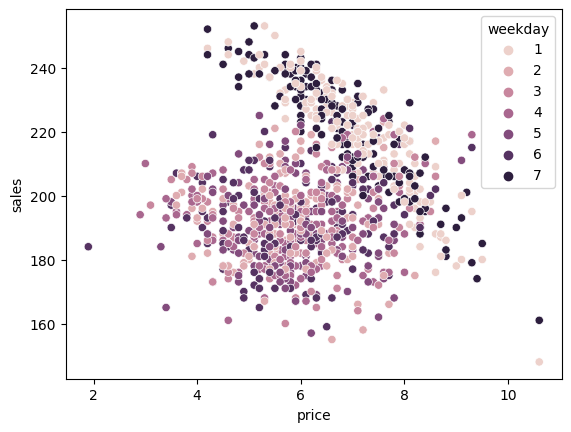

In [4]:
np.random.seed(123)
sns.scatterplot(data=test.sample(1000), x="price", y="sales", hue="weekday");

편향을 제거하기 위해서는 모델이 두 개 필요합니다. $M_t(X)$는 교란 변수로 처치(`price`)를 예측합니다. 이는 Frisch–Waugh–Lovell 정리의 첫 번째 단계에 해당합니다.

In [5]:
m_t = smf.ols("price ~ cost + C(weekday) + temp", data=test).fit()
debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test)})

이제 잔차를 계산합니다.

$$
\hat{t}_i = t_i - M_t(X_i)
$$

잔차는 편향이 없는 `treatment`나 교란 변수 $X$로부터 예측할 수 없는 양이라고 생각할 수 있습니다. 교란 변수는 이미 $t$를 예측하는 데 사용하므로 정의상 잔차는 $X$로 예측할 수 없습니다. $M_t(X_i)$은 편향을 고려하여 무작위만큼 좋은 $\hat{t}_i$를 생성한다고 생각할 수도 있습니다. 물론 $T$와 $Y$에 영향을 주는 모든 교란 변수가 $X$에 포함되어 있어야 합니다.

잔차가 어떻게 보이는지 그래프를 그려봅시다.

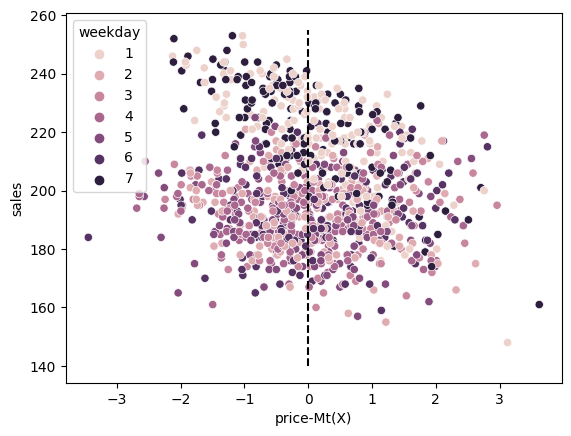

In [6]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales", hue="weekday")
plt.vlines(0, debiased_test["sales"].min(), debiased_test["sales"].max(), linestyles='--', color="black");

이제 주말 데이터는 더 이상 오른쪽 위에서 중앙으로 밀려났습니다. 게다가 `weekday`로 다른 가격(처치) 수준을 구별할 수 없습니다. $x$축에 표시된 잔차 $price-M_t(X)$은 원래 처치의 무작위 혹은 편향되지 않은 버전이라고 할 수 있습니다.

이것만으로도 데이터 내 편향을 제거하기에 충분합니다. 처치 잔차는 무작위로 할당된 것이나 마찬가지입니다. 하지만 우리는 더 할 수도 있습니다. 결과에 대한 잔차 데이터를 만들어 봅시다.

$$
\hat{y}_i = y_i - M_y(X_i)
$$

이는 Frisch–Waugh–Lovell의 두 번째 단계입니다. 데이터의 편향을 없애는 것은 아니지만 $y$의 분산을 줄임으로써 탄력성을 더 쉽게 추정할 수 있게 합니다. $\hat{y}_i$를 $X$로 예측할 수 없으며, $X$로 이미 설명된 $y_i$ 버전으로 생각할 수 있습니다. 정리해보죠. 우리는 모델 $M_y(X_i)$를 사용해 $X$로 $y$를 예측했습니다. $\hat{y}_i$는 예측의 오류에 해당합니다. 정의상 $\hat{y}_i$는 $X$로 예측할 수 없는 양입니다. $y$를 예측하기 위한 $X$의 모든 정보는 이미 사용되었습니다. 그렇다면 $\hat{y}_i$를 설명할 수 있는 유일한 방법은 $X$에 포함되지 않은, 처치 데이터뿐입니다.

In [7]:
m_y = smf.ols("sales ~ cost + C(weekday) + temp", data=test).fit()

debiased_test = test.assign(**{"price-Mt(X)":test["price"] - m_t.predict(test),
                               "sales-My(X)":test["sales"] - m_y.predict(test)})

두 변환을 거치면 `weekday`로는 가격 잔차와, 매출 잔차를 예측할 수 없습니다. 잔차를 예측할 수 있는 유일한 방법은 처치입니다. 위 그림에서는 가격 탄력성 방향을 알기 어렵습니다. 가격이 오르면 매출이 줄어든 것처럼 보이지만, 매출 편차가 워낙 커 확실하게 말하기는 어렵습니다.

이제 두 잔차를 그래프로 그리면 판매로 인해 가격이 하락한다는 사실이 훨씬 분명해집니다.

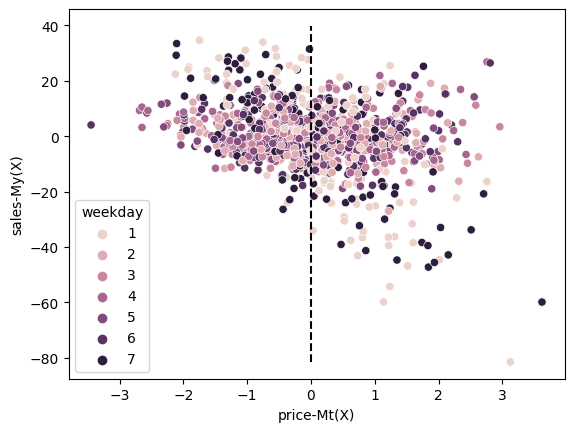

In [8]:
np.random.seed(123)
sns.scatterplot(data=debiased_test.sample(1000), x="price-Mt(X)", y="sales-My(X)", hue="weekday")
plt.vlines(0, debiased_test["sales-My(X)"].min(), debiased_test["sales-My(X)"].max(), linestyles='--', color="black");

잔차 데이터의 한 가지 작은 단점은 척도가 달라진다는 점입니다. 인과 효과를 설명하기 약간 어렵습니다. (가격 잔차 $-3$의 의미는 무엇일까요?) 무작위 데이터를 구축하는 편리함을 위해 지불해야 할 작은 비용이라고 생각합시다.

정리하면 처치를 예측해 편향 없는 처치 $\hat{t}$를 구성했습니다. 또한, 결과를 예측해 처치로만 설명할 수 있는 버전인 $\hat{y}$을 구성했습니다. 대체한 $\hat{y}$, $\hat{t}$는 우리가 원했던 편향되지 않은 데이터입니다. 무작위 데이터를 사용한 것처럼 인과 모델을 평가하는 데 사용할 수 있습니다.

확인하기 위해 다시 한번 훈련 데이터로 가격 탄력성에 대한 인과 모델을 만들어 보겠습니다.

In [9]:
m3 = smf.ols(f"sales ~ price*cost + price*C(weekday) + price*temp", data=train).fit()

그럼, 편향이 제거된 테스트 데이터로 탄력성을 예측해 봅시다.

In [10]:
def predict_elast(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

debiased_test_pred = debiased_test.assign(**{
    "m3_pred": predict_elast(m3, debiased_test),
})

debiased_test_pred.head()

,temp,weekday,cost,price,sales,price-Mt(X),sales-My(X),m3_pred
4166,23.8,3,1.0,6.5,189,0.476508,-2.196172,-0.168307
8719,32.0,4,1.0,6.0,216,-0.029962,10.602137,-3.735870
6562,15.5,6,0.5,6.1,160,0.552573,-16.905347,3.216761
6838,22.7,2,1.0,8.4,191,2.354426,2.089910,-0.169164
9925,23.2,1,0.5,8.0,218,1.472144,-1.662888,-12.287892


누적 탄력성을 그릴 때 여전히 예측 탄력성에 따라 데이터를 정렬하지만, 이제 잔차 데이터를 사용합니다. 마치 아래 회귀 모델로 $\beta_1$을 추정하는 것과 같습니다.

$$
\hat{y}_i = \beta_0 + \beta_1 \hat{t}_i + e_i
$$

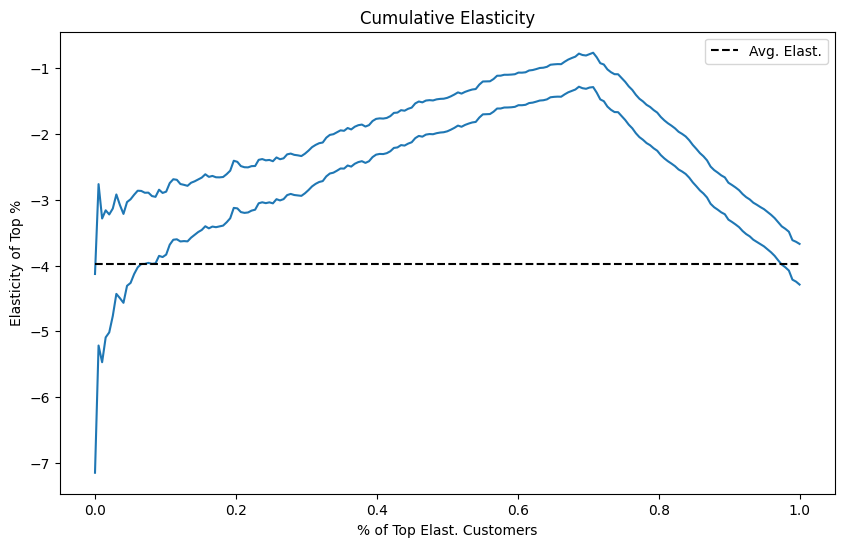

In [11]:
plt.figure(figsize=(10,6))

cumm_elast = cumulative_elast_curve_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_elast)))
plt.plot(x/x.max(), cumm_elast, color="C0")

plt.hlines(elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)"), 0, 1, linestyles="--", color="black", label="Avg. Elast.")
plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Elasticity of Top %")
plt.title("Cumulative Elasticity")
plt.legend();

물론 누적 이득 곡선도 그릴 수 있습니다.

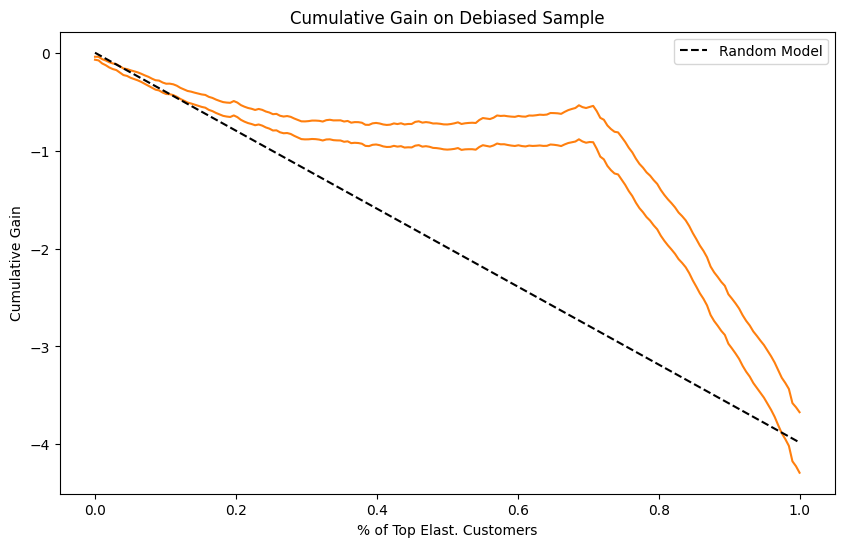

In [12]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales-My(X)", "price-Mt(X)", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="C1")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales-My(X)", "price-Mt(X)")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain on Debiased Sample")
plt.legend();

결과가 이전에 봤던 결과와 얼마나 유사한지 비교해봅시다. 이는 Frisch-Waugh-Lovell 정리가 경이롭게 작용했다는 증거입니다.

반대로 원래의 편향된 데이터를 사용할 때 누적 이득 곡선이 어떨지 확인해보겠습니다.

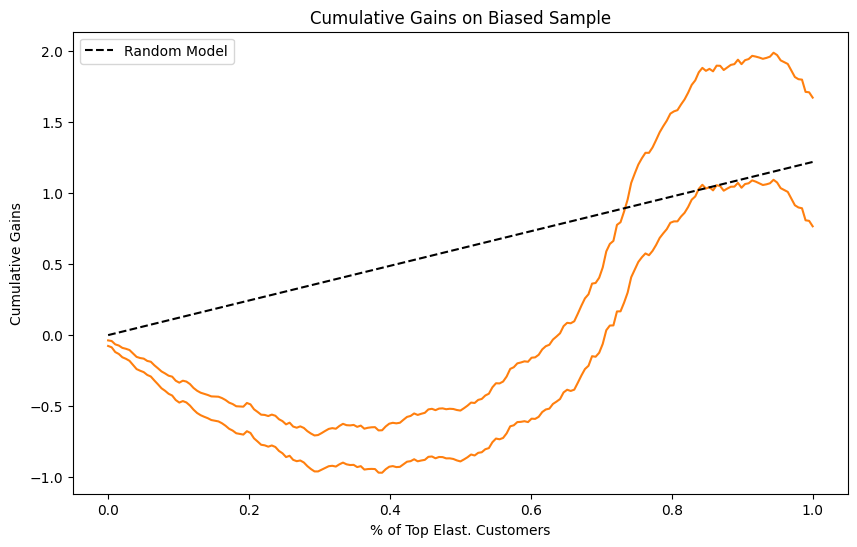

In [13]:
plt.figure(figsize=(10,6))

cumm_gain = cumulative_gain_ci(debiased_test_pred, "m3_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumm_gain)))
plt.plot(x/x.max(), cumm_gain, color="C1")

plt.plot([0, 1], [0, elast(debiased_test_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Elast. Customers")
plt.title("Cumulative Gains on Biased Sample")
plt.ylabel("Cumulative Gains")
plt.legend();

이제 평균 탄력성이 증가합니다. 마치 편향된 데이터에서 가격이 오를 때 매출이 올라가는 것과 같습니다. 결과적으로 누적 이득 곡선은 양수입니다. 아이스크림 가격이 오르면 구매가 감소하므로 말이 되지 않는 결과입니다. 평균 가격 탄력성이 이미 엉망이므로 어떠한 것도 말이 되지 않습니다. 편향된 데이터는 모델 평가에 사용해서는 안 됩니다.

## Orthogonalization with Machine Learning

2016년 논문을 통해 Victor Chernozhukov 등은 기계학습 모델로 직교화가 가능하다는 사실을 보였습니다. 이는 분명히 매우 최근의 방법으로 기계학습으로 무엇을 할 수 있고, 무엇을 할 수 없는지는 더 연구가 필요합니다. 그래도 기계학습을 활용하는 방법은 매우 흥미롭습니다.

기본 아이디어는 앞에서 배운 것과 거의 같습니다. 유일한 차이점은 편향을 제거하기 위해 기계 학습 모델을 사용한다는 것입니다.

$$
\begin{align}
\hat{y}_i &= y_i - M_y(X_i) \\
\hat{t}_i &= t_i - M_t(X_i)
\end{align}
$$

함정에 유의해야 합니다. 기계 학습 모델은 매우 강력해 데이터를 완벽하게 맞출 수 있습니다. 오히려 너무 잘 맞는 것이 문제입니다. 위의 방정식만 봐도 문제를 알 수 있습니다. $M_y$가 어떻게든 과적합 되면 잔차는 $0$에 매우 가까워집니다. 모든 값이 $0$인 데이터로는 $t$가 어떤 영향을 미치는지 찾기 어려울 것입니다. 마찬가지로 $M_t$가 어떻게든 과적합 되면 처치 잔차에 변동이 없게 되어 결과에 어떤 영향을 주는지 알 수 없을 것입니다.

과적합 문제를 다루기 위해서는 데이터를 분할 해야 합니다. 즉, 데이터 한 부분으로 모델을 학습하고 다른 부분으로 예측합니다. 가장 간단한 방법은 데이터를 반으로 나누어 절반으로 모델을 학습하고 나머지 절반으로 예측해보는 것입니다.

K-fold 교차 검증을 사용할 수도 있습니다. K-fold 교차 검증은 모든 데이터를 사용할 수 있는 장점이 있습니다.

![img](./data/img/orthogonal/kfold-cv.png)

K-fold 교차 검증은 `sklearn`의 `cross_val_predict` 함수를 사용하면 쉽게 구현할 수 있습니다.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

X = ["cost", "weekday", "temp"]
t = "price"
y = "sales"

folds = 5

np.random.seed(123)
m_t = RandomForestRegressor(n_estimators=100)
t_res = test[t] - cross_val_predict(m_t, test[X], test[t], cv=folds)

m_y = RandomForestRegressor(n_estimators=100)
y_res = test[y] - cross_val_predict(m_y, test[X], test[y], cv=folds)

이제 잔차를 새로운 열로 추가해 보겠습니다.

In [15]:
ml_debiased_test = test.assign(**{
    "sales-ML_y(X)": y_res,
    "price-ML_t(X)": t_res,
})
ml_debiased_test.head()

,temp,weekday,cost,price,sales,sales-ML_y(X),price-ML_t(X)
4166,23.8,3,1.0,6.5,189,-3.139333,0.918000
8719,32.0,4,1.0,6.0,216,2.842833,-0.265950
6562,15.5,6,0.5,6.1,160,-6.786667,0.677000
6838,22.7,2,1.0,8.4,191,-0.992333,1.965255
9925,23.2,1,0.5,8.0,218,-13.059183,1.956386


추가로 편향되지 않은 데이터를 그래프로 그려봅시다.

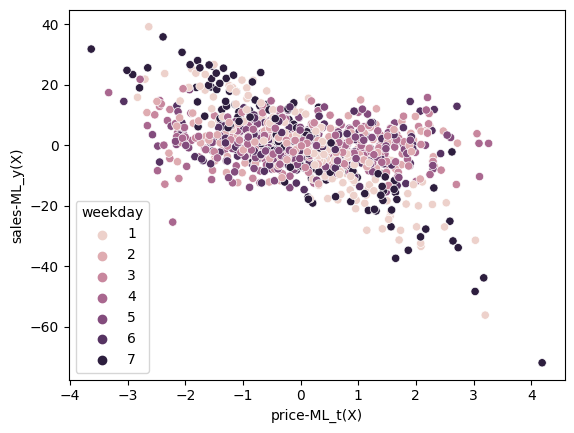

In [16]:
np.random.seed(123)
sns.scatterplot(data=ml_debiased_test.sample(1000),
                x="price-ML_t(X)", y="sales-ML_y(X)", hue="weekday");

또다시 판매에 대한 부정적인 가격 탄력성을 확인했습니다. 그래프는 단순한 선형 회귀 결과와 매우 유사한데 아마 매우 간단한 데이터이기 때문일 것입니다. 기계 학습 직교화는 더 복잡한 `feature`를 추정할 수 있는 것이 장점입니다. 선형 회귀로는 풀기 어려운 상호 작용과 비선형성을 학습할 수 있습니다. 일부 기계 학습 모델은 선형 회귀보다 실행이 훨씬 간단하기도 합니다. 범주형 데이터, 특이값 및 결측 데이터도 처리할 수 있습니다.

마무리하기 전에 데이터 과학자들이 종종 저지르는 일반적인 실수를 소개해 드리겠습니다. 처치나 결과가 이진이면 분류 모델을 사용하는 것이 더 낫다고 생각할 수 있습니다. 하지만 분류 모델은 효과가 없습니다. 직교화 이론은 회귀 모델에서만 작동합니다. 분류 모델 결과가 엉망인 것은 아니지만 이론으로 뒷받침할 수 없으므로 위험을 무릅쓰진 맙시다.

## Key Ideas

이번 장은 인과 평가를 위해 무작위 데이터의 필요성을 강조하는 것으로 시작하였습니다. 가장 안전한 방법은 무작위 데이터를 얻기 위해 실험을 해보는 것입니다. 실험이 어렵다면 데이터를 무작위처럼 보이도록 바꿀 수 있습니다.

여기서는 직교화를 사용하는 방법을 주제로 공부했습니다. 먼저 `feature` $X$로 `treatment` $t$를 예측하고 잔차를 얻는 모델을 만듭니다. 잔차의 정의에 따라 `treatment` 잔차는 `feature`와 독립입니다. 즉, `treatment` 잔차는 `feature`와 직교합니다. `treatment` 잔차는 $X$로 인한 모든 편향이 제거된 처리 버전으로 볼 수 있습니다.

이것만으로도 데이터를 무작위처럼 만들기에 충분합니다. 하지만 더 해볼 수도 있습니다. `feature` $X$로 `outcome` $y$를 예측하는 모델을 만들어 잔차를 얻습니다. `outcome` 잔차는 `feature`로 인한 모든 분산이 설명된 버전입니다. 분산이 줄어들어 `treatment`에 의한 인과 효과를 쉽게 볼 수 있습니다.

여기서는 인과 모델 평가를 위해 편향을 제거하기 위한 목적으로 직교화를 사용했습니다. 직교화는 다른데도 응용할 수 있습니다. 많은 인과 추론 모델은 첫 번째 전처리 단계로 직교화를 사용하곤 합니다. 현대 인과 추론 알고리즘은 직교화를 기반으로 하고 있습니다.

![img](./data/img/orthogonal/athlas.png)

## References 

The things I've written here are mostly stuff from my head. I've learned them through experience. This means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts.

This chapter is based on Victor Chernozhukov *et all* (2016), Double/Debiased Machine Learning for Treatment and Causal Parameters. You can also check Frisch, Ragnar; Waugh, Frederick V. (1933) original article, Partial Time Regressions as Compared with Individual Trends. 

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).